In [25]:
import pymystem3, pymorphy2
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from gensim.models.word2vec import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Uploading

In [2]:
df_train = pd.read_csv('train.csv', sep=';', index_col='id')

In [3]:
df_test = pd.read_csv('test.csv', sep=';', index_col='id')

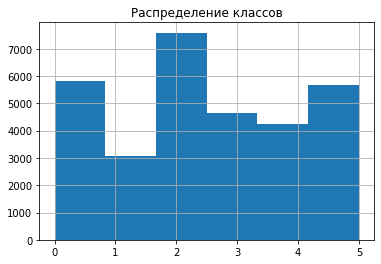

In [4]:
df_train['target'].hist(bins=len(set(df_train['target'])))
plt.title('Распределение классов');

Метки классов:
- **[0]** Строительство, недвижимость
- **[1]**  Медицина, фармацевтика
- **[2]**  Информационные технологии, интернет, телеком
- **[3]** Бухгалтерия, управленческий учет, финансы предприятия
- **[4]** Туризм, гостиницы, рестораны
- **[5]** Транспорт, логистика

## Text Preprocecssing

In [5]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.

morph = pymorphy2.MorphAnalyzer()

# conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
#             'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'PRTF':'ADJ', 'PRTS':'ADJ'}
            
tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy_fast(text, need_pos=False):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    with open("mystopwords.txt", encoding="utf-8") as file: 
        stop_words = file.read()
    words = []
    for t in set(tokens):
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].normal_form != 'быть' and \
                len(pv[0].normal_form) > 2 and \
                pv[0].normal_form not in stop_words and \
                pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

normalizePymorphy_fast('слон слон слон в посудной лавке дружный коллектив')

['слон', 'лавка', 'посудный']

In [6]:
%%time
df_train['NText'] = df_train['text'].map(lambda x:' '.join(normalizePymorphy_fast(x)))

CPU times: user 37.7 s, sys: 407 ms, total: 38.1 s
Wall time: 38.1 s


In [7]:
df_train.head()

,text,target,NText
id,,,
0,<p>В молодой и дружный коллектив динамично раз...,2,программа образование язык встреча соответстви...
1,<p><strong>Обязанности: </strong>- Прием входя...,2,корзина ведение покупатель испытательный алекс...
2,<p><strong>Федеральная сеть аптек </strong>в с...,1,участие образование сохранить рецептурный поез...
3,<strong>Обязанности:</strong> <ul> <li> <p>раз...,0,должность документ согласование аскуэ дружеств...
4,<p>Производителю сантехники тм Domani Spa треб...,5,погрузка-выгрузка екатеринбург указанный аккур...


In [8]:
%%time
df_test['NText'] = df_test['text'].map(lambda x:' '.join(normalizePymorphy_fast(x)))

CPU times: user 25.4 s, sys: 436 ms, total: 25.9 s
Wall time: 25.9 s


In [9]:
df_test.iloc[0].values

array(['<p><strong>В крупную компанию по организации и приготовлению корпоративного питания требуется - Бухгалтер калькулятор.</strong></p> <p><strong>Обязанности:</strong></p> <ul> <li>работа с технологическими картами</li> <li>расчет себестоимости блюд</li> <li>ведение номенклатур</li> <li>ведение документооборота производства</li> <li>ценообразование</li> <li>участие в проведении инвентаризации</li> </ul> <strong>Требования:</strong> <ul> <li>опыт работы в общепите бухгалтером-калькулятором</li> <li>умение работать в программе общепит &quot;Айко&quot; (или другой)</li> <li>внимательность и ответственное отношение к работе</li> </ul> <strong>Условия:</strong> <ul> <li>официальное трудоустройство с первого рабочего дня</li> <li>место работы Советский район</li> <li>график работы 5/2 с 9:00 до 18:00</li> <li>предоставляется бесплатное питание</li> </ul>',
       'советский проведение блюдо айко участие официальный питание производство инвентаризация ведение документооборот бухгалтер-ка

## Text Vectorizing

In [10]:
cv = CountVectorizer()

In [11]:
tfidf = TfidfVectorizer()

### Word2Vec

In [12]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 1  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 2     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

w2v_model = Word2Vec(df_train.NText, 
                     workers=num_workers, 
                     size=num_features,
                     min_count=min_word_count, 
                     window=context, 
                     sample=downsampling)

CPU times: user 1min 20s, sys: 329 ms, total: 1min 21s
Wall time: 42 s


In [13]:
w2v_model.init_sims(replace=True)

In [14]:
w2v_model.most_similar('п')

[('м', 0.44958484172821045),
 ('ф', 0.3694712519645691),
 ('в', 0.2692612409591675),
 ('с', 0.26331251859664917),
 ('у', 0.2557999789714813),
 ('з', 0.21091657876968384),
 ('т', 0.17970049381256104),
 ('н', 0.17615342140197754),
 ('ю', 0.1761188507080078),
 ('к', 0.15585611760616302)]

In [15]:
w2v_model.corpus_total_words

18340775

## Modeling

In [16]:
y = df_train['target']

In [17]:
w2v_dict = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
tfidf2 = TfidfVectorizer(w2v_dict).fit(df_train.text)
X = tfidf2.transform(df_train.text)
X.shape

(31063, 105185)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
model = LinearSVC(C=0.8)

In [20]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    print('model:', accuracy_score(y_test, model.predict(X_test)))

model: 0.9412711182622687
model: 0.9414225941422594
model: 0.9396426846933849
model: 0.9478428847392144
model: 0.9431470446126591


In [21]:
model.fit(X_train, y_train)
print('model:', accuracy_score(y_test, model.predict(X_test)))

model: 0.9431470446126591


In [22]:
print(classification_report(y_test, model.predict(X_test)))
print(confusion_matrix(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1166
           1       0.98      0.94      0.96       610
           2       0.96      0.96      0.96      1517
           3       0.95      0.92      0.93       931
           4       0.96      0.97      0.96       851
           5       0.92      0.93      0.93      1134

    accuracy                           0.94      6209
   macro avg       0.95      0.94      0.94      6209
weighted avg       0.94      0.94      0.94      6209

[[1086    2   14   14    8   42]
 [   6  576    8    6    6    8]
 [  29    1 1461   13    0   13]
 [  22    2   21  854   14   18]
 [   5    0   10    4  823    9]
 [  40    7   15   11    5 1056]]


Метки классов:
- **[0]** Строительство, недвижимость
- **[1]**  Медицина, фармацевтика
- **[2]**  Информационные технологии, интернет, телеком
- **[3]** Бухгалтерия, управленческий учет, финансы предприятия
- **[4]** Туризм, гостиницы, рестораны
- **[5]** Транспорт, логистика

In [23]:
for c in [0.001, 0.01, 0.1, 0.2, 0.8, 1, 2]:
    model = LinearSVC(C=c)
    model.fit(X_train, y_train)
    print('Linear SVC: C =', c, ', score =', accuracy_score(y_test, model.predict(X_test)))    

Linear SVC: C = 0.001 , score = 0.6390723143823482
Linear SVC: C = 0.01 , score = 0.8874214849412143
Linear SVC: C = 0.1 , score = 0.9339668223546465
Linear SVC: C = 0.2 , score = 0.9405701401191818
Linear SVC: C = 0.8 , score = 0.9431470446126591
Linear SVC: C = 1 , score = 0.9418585923659204
Linear SVC: C = 2 , score = 0.9408922531808664


## Predict

In [27]:
df_test_vectorized = tfidf2.transform(df_test.text)

In [37]:
df_test_vectorized = [text_to_vec(text) for text in df_test['NText']]

In [28]:
final_model = LinearSVC(C=0.8)

In [29]:
final_model.fit(X, y)

LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [30]:
pred = final_model.predict(df_test_vectorized)
pred

array([3, 2, 5, ..., 0, 4, 5])

## Submition

In [80]:
pd.DataFrame(zip(df_test.index, pred), columns = ['id','target']).to_csv('pred_hw10.csv', sep=',', index=False)

## Dump Final Model

In [24]:
import pickle

In [31]:
pickle.dump(final_model, open('final_model.pckl', 'wb'))

In [32]:
pickle.dump(tfidf2, open('tfidf.pckl', 'wb'))

## Memory Monitoring

In [102]:
# какие десять переменных занимают больше всего памяти
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train: 199.0 MiB
                       df_test: 123.6 MiB
                      tmp_dict:  5.0 MiB
                     tmp_dict2:  5.0 MiB
                 all_sentences:  3.3 MiB
                             y:  1.7 MiB
                         nones: 576.1 KiB
                        nones2: 576.1 KiB
                index2word_set: 512.2 KiB
                       y_train: 339.8 KiB


In [103]:
def reduce_mem_usage(df):
    """ function by Bartosz Mikulski
        https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [104]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 2.91 MB
Memory usage after optimization is: 2.91 MB
Decreased by 0.0%
Memory usage of dataframe is 0.71 MB
Memory usage after optimization is: 0.71 MB
Decreased by 0.0%


In [ ]:
%reset